# Age, Gender and Ethnicity Predictions

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from keras.models import Sequential
from keras.layers import Conv2D, Dropout, BatchNormalization, Flatten, Dense, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.optimizers import Adam
from keras.src.legacy.preprocessing.image import ImageDataGenerator

from sklearn.metrics import mean_absolute_error, confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, roc_curve, auc, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('age_gender.csv')

In [8]:
df.head()


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,23705.0,33.300907,19.885708,1.0,23.0,29.0,45.0,116.0
ethnicity,23705.0,1.269226,1.345638,0.0,0.0,1.0,2.0,4.0
gender,23705.0,0.477283,0.499494,0.0,0.0,0.0,1.0,1.0


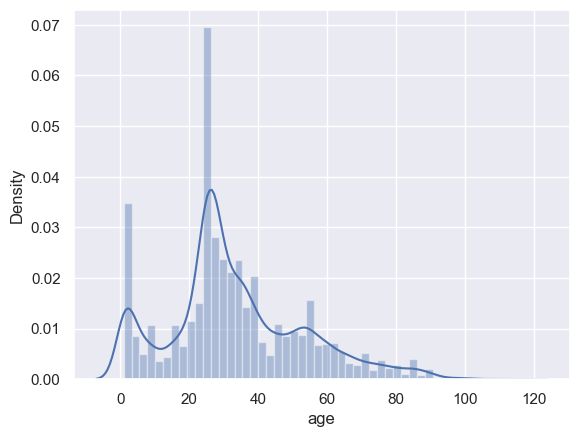

In [41]:
# Age
sns.distplot(df['age']);

<Axes: xlabel='gender', ylabel='count'>

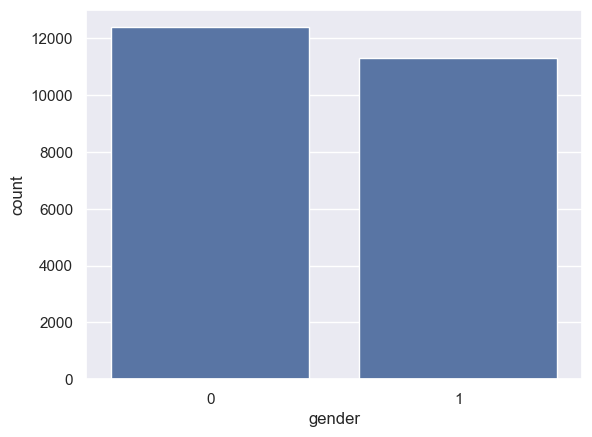

In [38]:
# Gender
sns.countplot(x = df['gender'], data = df)

<Axes: xlabel='ethnicity', ylabel='count'>

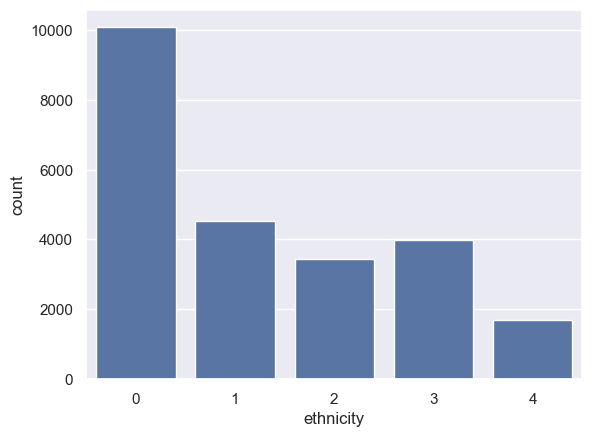

In [39]:
#ethnicity
sns.countplot(x = df['ethnicity'], data = df)


In [8]:
df['pixels'] = df['pixels'].map(lambda x: np.array(x.split(' '), dtype=np.float32).reshape(48, 48))

In [9]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2)

X = np.array(df['pixels'].to_list())
X_reshaped = X.reshape(X.shape[0], 48, 48, 1)

datagen.fit(X_reshaped)

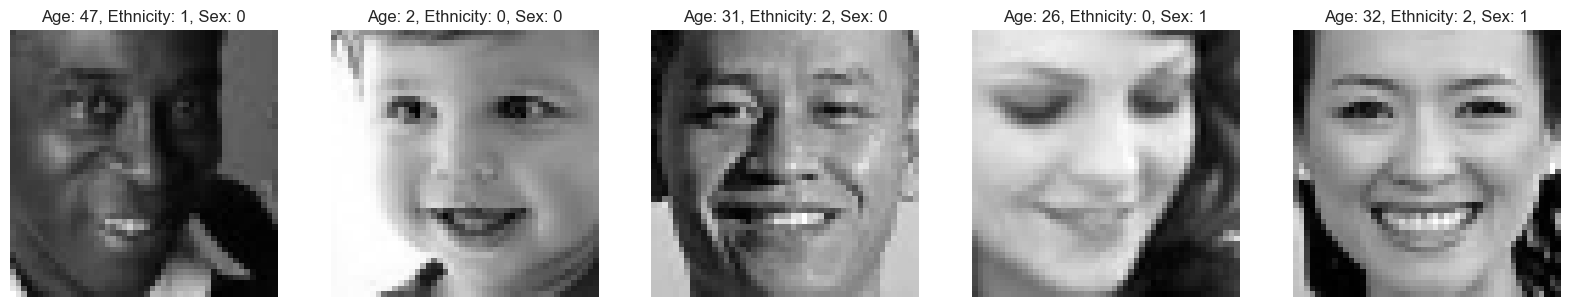

In [10]:
# Plot some pictures
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

for i in range(5):
    random_face = np.random.choice(len(df))
    
    age = df['age'][random_face]
    ethnicity = df['ethnicity'][random_face]
    gender = df['gender'][random_face]
    
    axes[i].set_title('Age: {0}, Ethnicity: {1}, Sex: {2}'.format(age, ethnicity, gender))
    axes[i].imshow(df['pixels'][random_face], cmap = 'gray')
    axes[i].axis('off')


## CNN

In [11]:
# Normalise images
if np.max(X_reshaped) > 1: X_reshaped = X_reshaped / 255

In [12]:
input_shape = X_reshaped.shape[1:] 

n_epochs = 30
batch_size = 64

## Age prediction

In [13]:
y = df['age'].values

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [15]:
print('X Train Shape: ', X_train.shape)
print('y Train Shape: ', y_train.shape)
print('X Test Shape: ', X_test.shape)
print('y Test Shape: ', y_test.shape)

X Train Shape:  (18964, 48, 48, 1)
y Train Shape:  (18964,)
X Test Shape:  (4741, 48, 48, 1)
y Test Shape:  (4741,)


In [16]:
age_model = Sequential()

age_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))  
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(BatchNormalization())

age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.3))
age_model.add(BatchNormalization())

age_model.add(Conv2D(512, kernel_size=(3,3), activation='relu', padding='same'))
age_model.add(MaxPooling2D(pool_size=(2,2)))
age_model.add(Dropout(0.5))
age_model.add(BatchNormalization())

age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dropout(0.4))
age_model.add(Dense(1)) 

age_model.compile(optimizer='adam', loss='mse', metrics = ['mae'])

age_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 23, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 10, 10, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,553,729 (9.74 MB)

 Trainable params: 2,551,809 (9.73 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [19]:
checkpoint = ModelCheckpoint('age_model.keras', monitor='val_loss', save_best_only=True, mode='min')
callbacks = [checkpoint]

In [20]:
history = age_model.fit(X_train, y_train,
                        epochs=30,   
                        batch_size=batch_size, 
                        callbacks=callbacks,
                        validation_data=(X_test, y_test)) 

Epoch 1/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 255s 842ms/step - loss: 372.7627 - mae: 14.1077 - val_loss: 1761.6356 - val_mae: 38.2412
Epoch 2/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 107s 359ms/step - loss: 146.2173 - mae: 8.9416 - val_loss: 721.4167 - val_mae: 23.3627
Epoch 3/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 303s 1s/step - loss: 124.7699 - mae: 8.1953 - val_loss: 470.8338 - val_mae: 18.4553
Epoch 4/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 195s 656ms/step - loss: 116.5267 - mae: 7.9087 - val_loss: 222.5264 - val_mae: 11.1410
Epoch 5/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 252s 850ms/step - loss: 100.2962 - mae: 7.3991 - val_loss: 107.5235 - val_mae: 7.2993
Epoch 6/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 154s 518ms/step - loss: 98.0772 - mae: 7.2774 - val_loss: 121.0858 - val_mae: 7.7864
Epoch 7/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - loss: 88.7759 - mae: 6.9508 - val_loss: 135.3036 - val_mae: 8.1272
Epoch 8/30
297/297 ━━━━━━━━━━━━━━━━━━━━ 112s 375ms/step - loss: 84.8774 - mae: 6.7747 - val_loss: 104.8481 - val_mae: 7.

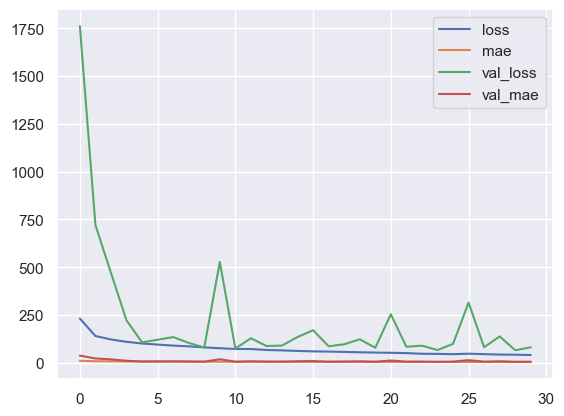

In [21]:
pd.DataFrame(history.history).plot();

In [23]:
from tensorflow.keras.models import load_model
age_model = load_model('age_model.keras')

In [24]:
valid_score = age_model.evaluate(X_test, y_test, verbose=1)

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - loss: 66.8909 - mae: 5.8014


In [25]:
# Make predictions 
y_pred = age_model.predict(X_test) 

149/149 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step


In [26]:
print("MAE: {}".format(mean_absolute_error(y_test, y_pred)))

MAE: 5.822966586610633


In [27]:
print('MSE: {}'.format(mean_squared_error(y_test, y_pred)))

MSE: 66.13275815291594


In [28]:
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_test, y_pred))))

RMSE: 8.132204999439939


In [29]:
print('R2 Score: {}'.format(r2_score(y_test, y_pred)))

R2 Score: 0.8288924222988522


In [30]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

In [31]:
sozluk = {'Mean Absolute Error' : mae,
          'Mean Squared Error' : mse,
          'Root Mean Squared Error' : rmse, 
          'R2 Score' : r2}

sozluk

{'Mean Absolute Error': 5.822966586610633,
 'Mean Squared Error': 66.13275815291594,
 'Root Mean Squared Error': 8.132204999439939,
 'R2 Score': 0.8288924222988522}

In [32]:
df2 = pd.DataFrame(sozluk, index = ['Age Model Metrics'])
df2

,Mean Absolute Error,Mean Squared Error,Root Mean Squared Error,R2 Score
Age Model Metrics,5.822967,66.132758,8.132205,0.828892


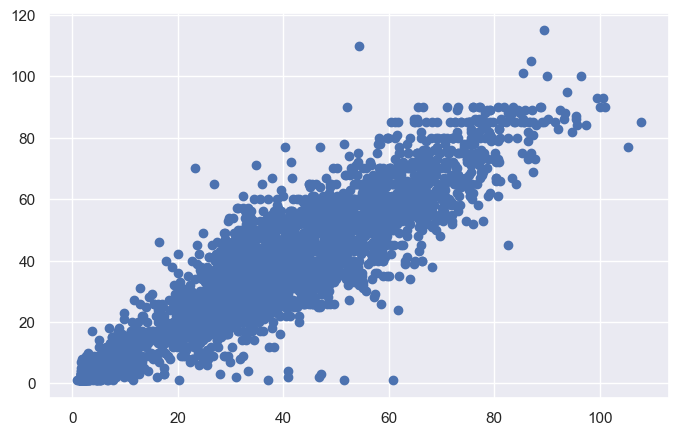

In [33]:
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, y_test); 

## Gender prediction

In [ ]:
# Set y
y = df['gender'].values

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [ ]:
gender_model = Sequential()

gender_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#gender_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.4))
gender_model.add(BatchNormalization())

gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
gender_model.add(MaxPooling2D(pool_size=(2,2)))
gender_model.add(Dropout(0.5))
gender_model.add(BatchNormalization())

gender_model.add(Flatten())

gender_model.add(Dense(64, activation='relu'))
gender_model.add(Dropout(0.4))

gender_model.add(Dense(1, activation='sigmoid'))

gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) 

gender_model.summary()

In [ ]:
plot_model(gender_model, to_file='gender_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint('gender_model.h5', monitor='val_loss', save_best_only=True, mode='min')
callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1), checkpoint]

In [ ]:
history = gender_model.fit(X_train, y_train, 
                           epochs=15,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

In [ ]:
gender_model = load_model('gender_model.h5')

In [ ]:
# Metrics
valid_score = gender_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1])) 

In [ ]:
y_pred = gender_model.predict(X_test) 
y_pred = [0 if i <0.5 else 1 for i in y_pred ] 

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d'); 

In [ ]:
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """

    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

In [ ]:
plot_roc_curve(y_test, y_pred)
print(f'Gender model 1 AUC score: {roc_auc_score(y_test, y_pred)}')

### Ethnicity Prediction

In [ ]:
y = df['ethnicity'].values
y = to_categorical(y, num_classes=5)

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

In [ ]:
ethnicity_model = Sequential()

ethnicity_model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
#ethnicity_model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(Dropout(0.4))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
ethnicity_model.add(MaxPooling2D(pool_size=(2,2)))
ethnicity_model.add(Dropout(0.5))
ethnicity_model.add(BatchNormalization())

ethnicity_model.add(Flatten())

ethnicity_model.add(Dense(64, activation='relu'))
ethnicity_model.add(Dropout(0.4))

ethnicity_model.add(Dense(5, activation='softmax')) 

ethnicity_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

ethnicity_model.summary()

In [ ]:
plot_model(ethnicity_model, to_file='ethnicity_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
checkpoint = ModelCheckpoint('ethnicity_model.h5', monitor='val_loss', save_best_only=True, mode='min')

callbacks = [EarlyStopping(patience=4, monitor='val_accuracy', mode='max'), 
              ReduceLROnPlateau(patience=2, verbose=1), checkpoint]

In [ ]:
history = ethnicity_model.fit(X_train, y_train, 
                           epochs=15,
                           batch_size=batch_size,
                           callbacks=callbacks,
                           validation_data=(X_test, y_test))

In [ ]:
ethnicity_model = load_model('ethnicity_model.h5')

In [ ]:
# Metrics
valid_score = ethnicity_model.evaluate(X_test, y_test, verbose=1)
print('Accuracy for test set: {0}'.format(valid_score[1]))

In [ ]:
y_pred =ethnicity_model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap='Greens', cbar=False, annot=True, fmt='d'); 

In [ ]:
cm

In [ ]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

plt.figure(figsize=(7, 7))
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='Sınıf %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Pozitif Rate')
plt.ylabel('True Pozitif Rate')
plt.title('Ethnicity Model ROC Eğrisi')
plt.legend(loc="lower right")
plt.show()


In [ ]:
fpr

In [ ]:
tpr